After concluding Phase 1, we continue with Phase 2: Training

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from typing import Tuple
from keras.utils import load_img
import keras.utils as image
from keras.models import load_model, Sequential, Model
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import random
from sklearn.utils import shuffle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_feature_maps_for_convs, encode_labels, Dataloader
from keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from keras.applications.inception_v3 import InceptionV3


tf.random.set_seed(222)

random.seed(222)

# 2. Training

This notebook is divided into the following sections: <br>
[1. Preparation & Sanity checks](#first) <br>
[2. Visualizing feature maps](#second) <br>
[3. Model Training](#third) <br>
&nbsp; [3.1 Vanilla CNN](#fourth) <br>
&nbsp; [3.2 Divided Task](#fifth) <br>
&nbsp; [3.3 Inception_v3](#sixth) <br>

## Preparation & Sanity checks <a id="#first"></a>

First, we split our data into training, validation and test set.
Similar to the paper with the highest number of upvotes on paperswithcode [[5]](https://arxiv.org/pdf/2209.07326v3.pdf), we split our data into 90% training, 5% validation and 5% test set. As we found out before, we need to be aware of the class imbalance in the dataset. However, according to [[5]](https://arxiv.org/pdf/2209.07326v3.pdf), we apply our data split for each of the classes separately, i.e. for each class, 90% of the samples are used for training and 5% for validation and testing, respectively. <br>
Since ~50k images is a whole lot, we also create a smaller train test validation split with 100 samples per class.

In [6]:
import pandas as pd

data = pd.read_csv("data.csv")
data = data.assign(label=data["plant"] + data["disease"])
display(data["label"].nunique())

train_small = pd.DataFrame()
test_small = pd.DataFrame()
validation_small = pd.DataFrame()

train_small = pd.DataFrame() 
train = pd.DataFrame()
test_small = pd.DataFrame()
test = pd.DataFrame()
validation_small = pd.DataFrame()
validation = pd.DataFrame()
for label in data["label"].unique():
    data_for_label = data[data["label"] == label].reset_index(drop=True)

    # small
    train_current_small = data_for_label[:90]
    validation_current_small = data_for_label[90:95]
    test_current_small = data_for_label[95:100]

    # all data
    train_current_label, rest = train_test_split(
        data_for_label, test_size=0.1
    )
    test_current_label, validation_current_label = train_test_split(
        rest, test_size=0.5
    )

    train = pd.concat([train, train_current_label])
    validation = pd.concat([validation, validation_current_label])
    test = pd.concat([test, test_current_label])
    train_small = pd.concat([train_small, train_current_small])
    validation_small = pd.concat([validation_small, validation_current_small])
    test_small = pd.concat([test_small, test_current_small])
print(
    "Sanity check for small: ",
    len(train_small) + len(test_small) + len(validation_small)
    == data["label"].nunique() * 100,
)

train = shuffle(train, random_state=42)
test = shuffle(test, random_state=42)
test.to_csv("test.csv", index=False) # save test for 3_evaluation
validation = shuffle(validation, random_state=42)
train_small = shuffle(train_small, random_state=42)
test_small = shuffle(test_small, random_state=42)
validation_small = shuffle(validation_small, random_state=42)
print("Number of samples: ", len(data))
print("Number of training samples: ", len(train))
print("Number of test samples: ", len(test))
print("Number of validation: ", len(validation))
print("Sanity check: ", len(train) + len(test) + len(validation) == len(data))

38

Sanity check for small:  True
Number of samples:  54281
Number of training samples:  48836
Number of test samples:  2716
Number of validation:  2729
Sanity check:  True


<details>
    <summary>
    GPT
    </summary>
    how do I rewrite this code to prevent from the SettingWithCopyWarning:
    Code: """
    data["label"] = data["plant"] + data["disease"]
    """
</details>

As a sanity check, we train a random forest classifier and see whether it performs better than random guessing. Since we have 38 different classes, random guessing should achieve an accuracy of roughly 1/38 (~3%) on our "small" (and balanced) datasets.

In [7]:
def load_and_label_data(data: pd.DataFrame) -> Tuple:
    X, y = [], []
    for _, row in data.iterrows():
        # based on the code from the exercise
        img = load_img(row["path"], target_size=(256, 256, 3))
        img = image.img_to_array(img)
        img = img / 255
        X.append(img)
        y.append(row["label"])
    return X, y


In [8]:
X_train, y_train = load_and_label_data(train_small)
X_validation, y_validation = load_and_label_data(validation_small)
X_test, y_test = load_and_label_data(test_small)

# as discussed in the exercise, we need to flatten the data for "regular machine learning"
X_train_flat = [element.flatten() for element in X_train]
X_val_flat = [element.flatten() for element in X_validation]

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train_flat, y_train)
predictions = rf.predict(X_val_flat)

print(accuracy_score(y_validation, predictions))

# release memory
del X_train_flat, X_val_flat, X_train, y_train, X_test, y_test

0.5526315789473685


An accuracy of ~0.55 appears reasonable. Next up, we try and train a convolutional neural network. The following code is mostly based on what we learned during the exercise. The goal is to overfit a model on the small training set as a sanity check.

In [9]:
encoder = OneHotEncoder(sparse_output=False)

y_train_encoded, y_validation_encoded, y_test_encoded = encode_labels(
    encoder,
    np.array(train_small["label"]).reshape(-1, 1),
    np.array(validation_small["label"]).reshape(-1, 1),
    np.array(test_small["label"]).reshape(-1, 1),
)

training_set_small = Dataloader(train_small["path"], y_train_encoded, 64)
test_set_small = Dataloader(test_small["path"], y_test_encoded, 64)
validation_set_small = Dataloader(validation_small["path"], y_validation_encoded, 64)

In [10]:
model = Sequential(
    [
        Conv2D(
            8, (3, 3), activation="relu", input_shape=((256, 256, 3)), padding="same"
        ),
        MaxPooling2D(2, 2),
        Conv2D(16, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(38, activation="softmax"),
    ]
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0

In [11]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history = model.fit(
    training_set_small,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_set_small),
    callbacks=[callback],
)

model.save("models/overfitted_sanity.h5")

Epoch 1/20
54/54 [==============================] - 44s 805ms/step - loss: 3.5718 - accuracy: 0.0567 - val_loss: 3.3165 - val_accuracy: 0.1000
Epoch 2/20
54/54 [==============================] - 42s 773ms/step - loss: 2.7514 - accuracy: 0.2401 - val_loss: 2.1994 - val_accuracy: 0.3789
Epoch 3/20
54/54 [==============================] - 43s 802ms/step - loss: 1.8209 - accuracy: 0.4620 - val_loss: 1.7674 - val_accuracy: 0.4474
Epoch 4/20
54/54 [==============================] - 44s 805ms/step - loss: 1.2957 - accuracy: 0.6167 - val_loss: 1.5101 - val_accuracy: 0.4947
Epoch 5/20
54/54 [==============================] - 44s 810ms/step - loss: 0.9188 - accuracy: 0.7161 - val_loss: 1.2269 - val_accuracy: 0.6421
Epoch 6/20
54/54 [==============================] - 43s 802ms/step - loss: 0.5967 - accuracy: 0.8129 - val_loss: 1.1564 - val_accuracy: 0.6316
Epoch 7/20
54/54 [==============================] - 44s 805ms/step - loss: 0.4111 - accuracy: 0.8775 - val_loss: 1.4463 - val_accuracy: 0.6526

Based on the training and validation results above, we conclude that the model appears to learn something from out data. Based on the divergence between training and validation accuracy, we assume that the model is overfitting. To verify this assumption with a visualization, let's plot the learning curve.

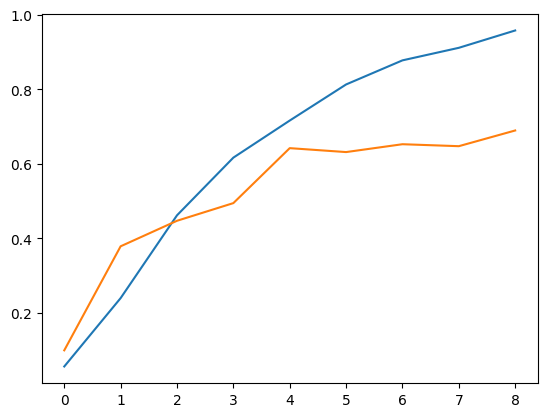

In [12]:
sns.lineplot(history.history['accuracy'])
sns.lineplot(history.history['val_accuracy'])

plt.show()

The divergence between training and validation accuracy starting approx. from epoch 4 shows that the model is actually overfitting. Thus, we consider our sanity checks successful.

## Visualizing feature maps <a id="second"></a>
Next, we evaluate the use of transfer learning. <a id="explain"></a>Based on the assumption that it might be easier for a model to predict only the plant or only the disease instead of predicting plant and disease at once, we divide the labels of our images, such that we can train one model to predict only the plant and a second one to predict only the disease. For our final prediction, we could then concatenate the resulting labels from our two models to get the final result. <br> To make training more efficient, we could transfer (some of) the trained weights from our first model for plant prediction to the second model for disease prediction, as the learned features might be similar up to a certain point (e.g. low level features might appear similar). <br> To make an educated guess whether this makes sense, we conduct the following steps:
- train two networks for the two subtasks on our small subset of the data 
- visualize the feature maps of the two resulting models
- If the feature maps from all convolutional layers appear similar
    - use the pre-trained network from the first model as a fixed feature extractor
- Else
    - fine-tune (part of) the first model for diseases

In [13]:
encoder_plants = OneHotEncoder(sparse_output=False)
y_train_plants, y_validation_plants, y_test_plants = encode_labels(
    encoder_plants,
    np.array(train_small["plant"]).reshape(-1, 1),
    np.array(validation_small["plant"]).reshape(-1, 1),
    np.array(test_small["plant"]).reshape(-1, 1),
)

training_set_plants_small = Dataloader(train_small["path"], y_train_plants, 64)
validation_set_plants_small = Dataloader(validation_small["path"], y_validation_plants, 64)
test_set_plants_small = Dataloader(test_small["path"], y_validation_plants, 64)

In [14]:
model_plants = Sequential(
    [
        Conv2D(
            8, (3, 3), activation="relu", input_shape=((256, 256, 3)), padding="same"
        ),
        MaxPooling2D(2, 2),
        Conv2D(16, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(64, activation="relu"),
        Dense(train_small["plant"].nunique(), activation="softmax"),
    ]
)
model_plants.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_plants.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)      

In [15]:
history = model_plants.fit(
    training_set_plants_small,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_set_plants_small),
    callbacks=[callback],
)

model_plants.save("models/plants_small.h5")

Epoch 1/20


54/54 [==============================] - 46s 825ms/step - loss: 2.3777 - accuracy: 0.2547 - val_loss: 2.1086 - val_accuracy: 0.3421
Epoch 2/20
54/54 [==============================] - 43s 792ms/step - loss: 1.9166 - accuracy: 0.4067 - val_loss: 1.7241 - val_accuracy: 0.4211
Epoch 3/20
54/54 [==============================] - 43s 788ms/step - loss: 1.4978 - accuracy: 0.5190 - val_loss: 1.2433 - val_accuracy: 0.5947
Epoch 4/20
54/54 [==============================] - 43s 799ms/step - loss: 1.1318 - accuracy: 0.6386 - val_loss: 1.1189 - val_accuracy: 0.6211
Epoch 5/20
54/54 [==============================] - 43s 792ms/step - loss: 0.8824 - accuracy: 0.7064 - val_loss: 1.0333 - val_accuracy: 0.6474
Epoch 6/20
54/54 [==============================] - 45s 823ms/step - loss: 0.6653 - accuracy: 0.7860 - val_loss: 0.7747 - val_accuracy: 0.7579
Epoch 7/20
54/54 [==============================] - 45s 831ms/step - loss: 0.4654 - accuracy: 0.8477 - val_loss: 0.7666 - val_accuracy: 0.7947
Epoch 8/20

In [16]:
encoder_diseases = OneHotEncoder(sparse_output=False)
y_train_diseases, y_validation_diseases, y_test_diseases = encode_labels(
    encoder_diseases,
    np.array(train_small["disease"]).reshape(-1, 1),
    np.array(validation_small["disease"]).reshape(-1, 1),
    np.array(test_small["disease"]).reshape(-1, 1),
)

training_set_diseases_small = Dataloader(train_small["path"], y_train_diseases, 64)
validation_set_diseases_small = Dataloader(validation_small["path"], y_validation_diseases, 64)
test_set_diseases_small = Dataloader(test_small["path"], y_test_diseases, 64)

In [17]:
model_disease = Sequential(
    [
        Conv2D(
            8, (3, 3), activation="relu", input_shape=((256, 256, 3)), padding="same"
        ),
        MaxPooling2D(2, 2),
        Conv2D(16, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(64, activation="relu"),
        Dense(21, activation="softmax"),
    ]
)
model_disease.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_disease.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)      

In [18]:
history = model_disease.fit(
    training_set_diseases_small,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_set_diseases_small),
    callbacks=[callback],
)

model_disease.save("models/disease_small.h5")

Epoch 1/20


54/54 [==============================] - 47s 851ms/step - loss: 2.6281 - accuracy: 0.3041 - val_loss: 2.4735 - val_accuracy: 0.3158
Epoch 2/20
54/54 [==============================] - 45s 824ms/step - loss: 2.3607 - accuracy: 0.3371 - val_loss: 2.0716 - val_accuracy: 0.3474
Epoch 3/20
54/54 [==============================] - 46s 848ms/step - loss: 2.0877 - accuracy: 0.3687 - val_loss: 1.7671 - val_accuracy: 0.4053
Epoch 4/20
54/54 [==============================] - 44s 820ms/step - loss: 1.7252 - accuracy: 0.4526 - val_loss: 1.3854 - val_accuracy: 0.5684
Epoch 5/20
54/54 [==============================] - 45s 830ms/step - loss: 1.3769 - accuracy: 0.5447 - val_loss: 1.2260 - val_accuracy: 0.5895
Epoch 6/20
54/54 [==============================] - 48s 891ms/step - loss: 1.1224 - accuracy: 0.6345 - val_loss: 1.0921 - val_accuracy: 0.6263
Epoch 7/20
54/54 [==============================] - 48s 886ms/step - loss: 0.9035 - accuracy: 0.6915 - val_loss: 0.9771 - val_accuracy: 0.6632
Epoch 8/20

During training, we note that both of the models appear to be overfitting again. We might be able to mitigate this problem e.g. by experimenting with regularization, different dropout rates, or batch-normalization. However, we ignore it for now as we will use a lot more data for training in the later stages of this project, which could also prevent overfitting. <br><br>
As mentioned before, after training both of our models, we compare the resulting feature maps of the respective convolutional layers to see whether the learned features of the two models appear similar.

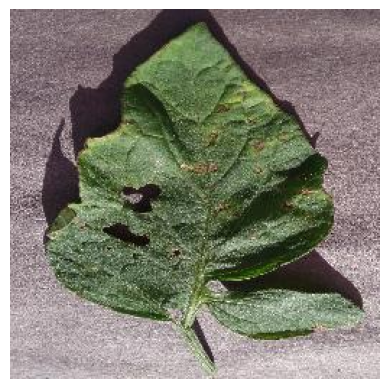

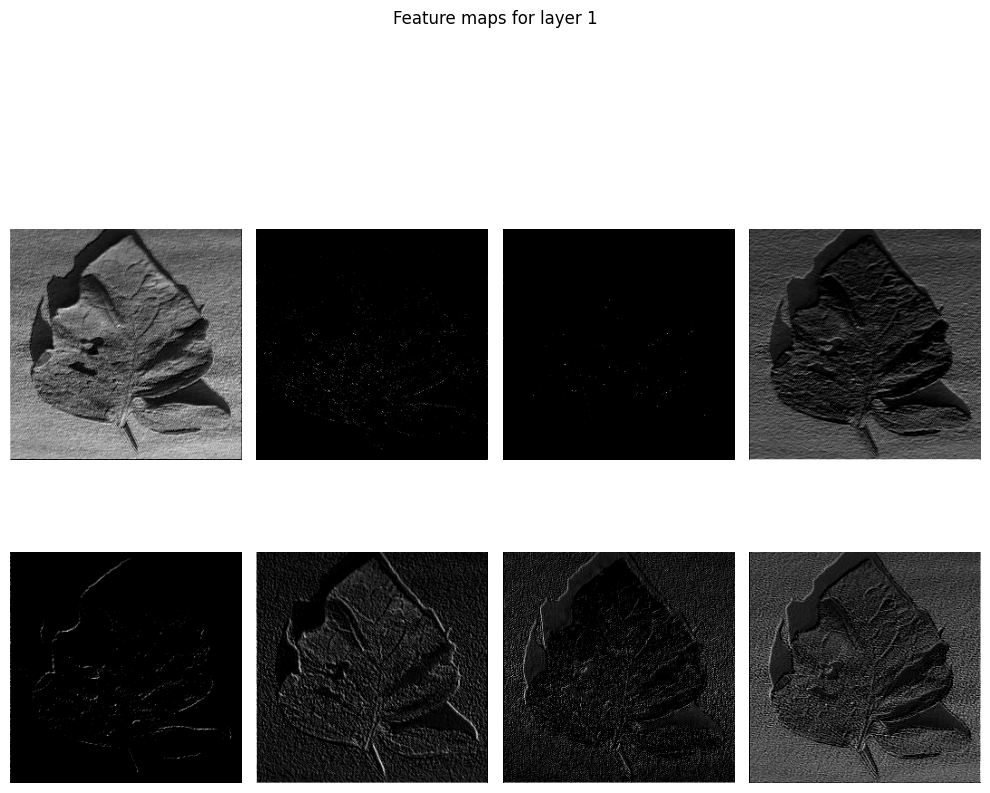

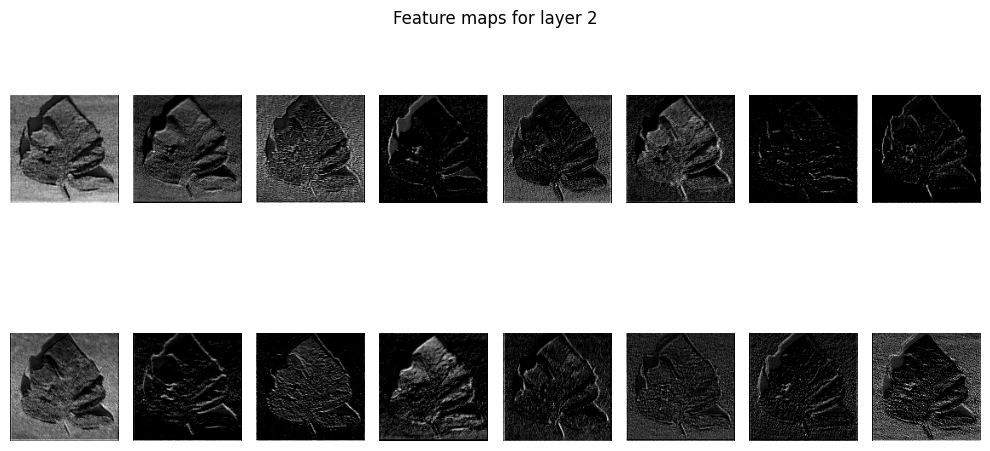

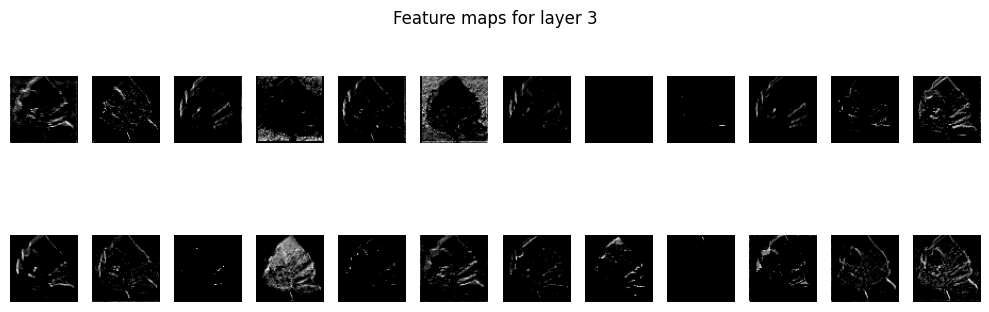

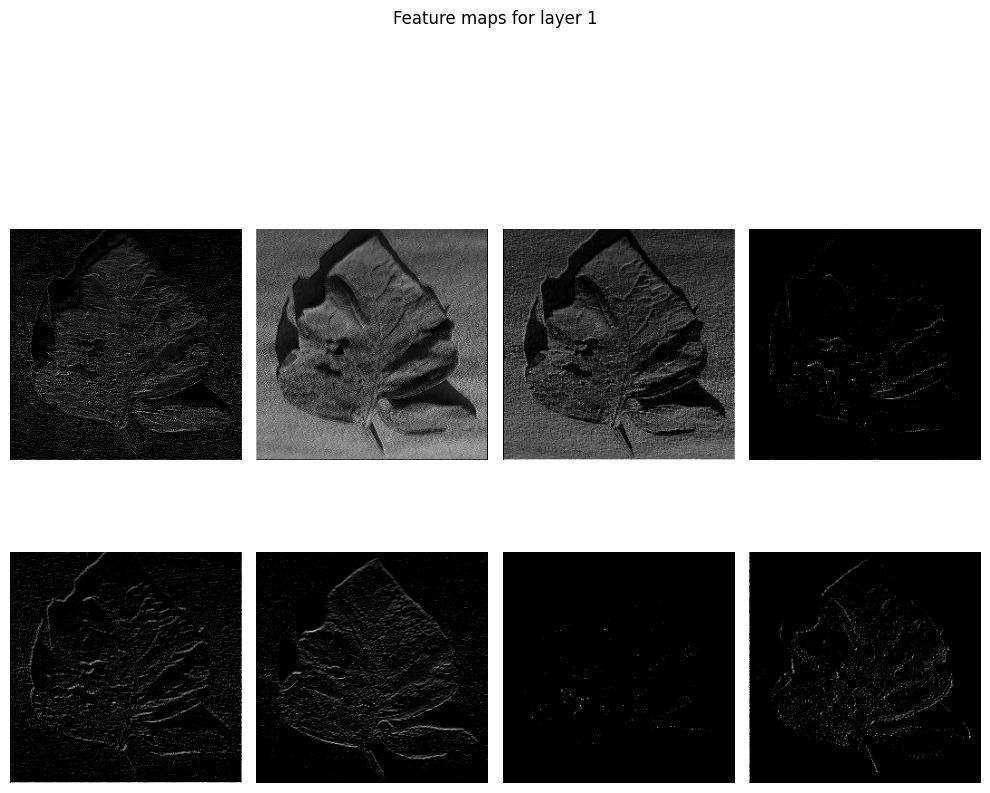

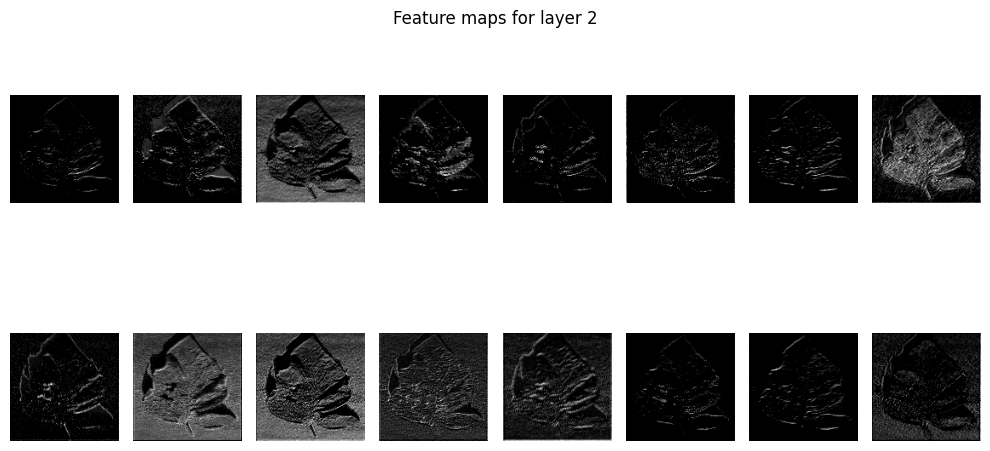

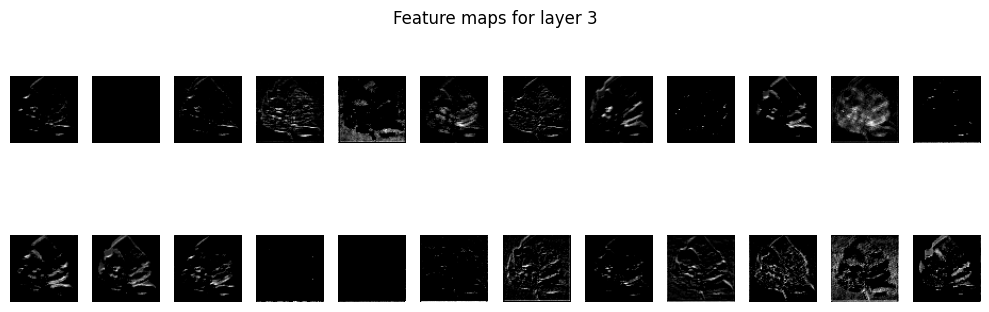

In [19]:
example_1 = test_set_plants_small.__getitem__(0)

# plot the sample at hand
plt.imshow(example_1[0][0])
plt.axis("off")
plt.show()

# https://stackoverflow.com/questions/67051417/how-to-predict-a-single-sample-with-keras
plot_feature_maps_for_convs(num_convs=3, num_filters_first=8, sample=example_1[0][0][None], model=model_plants)
plot_feature_maps_for_convs(3, 8, example_1[0][0][None], model_disease)

Based on the feature maps shown above, I think it might make sense to re-use the first two convolutional layers from the plant model for our disease model (disclaimer: subjective decision).

In [21]:
first_model = load_model("models/plants_small.h5")
first_conv_layer = first_model.layers[0]
second_conv_layer = first_model.layers[2]
first_conv_layer.trainable=False
second_conv_layer.trainable=False

transfer_model = tf.keras.models.Sequential([
    first_conv_layer,
    MaxPooling2D(2, 2),
    second_conv_layer,
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dropout(0.2),
    Dense(128, activation="relu"),
    Dropout(0.1),
    Dense(64, activation="relu"),
    Dense(21, activation="softmax"),
])

transfer_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
transfer_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 32)      

The first two conv2d layers have 224 and 1,168 parameters respectively, which leads to 224 + 1,168 = 1,392 non-trainable parameters.

In [22]:
history = transfer_model.fit(
    training_set_diseases_small,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_set_diseases_small),
    callbacks=[callback],
)

transfer_model.save("models/transfer_small.h5")

Epoch 1/20


54/54 [==============================] - 22s 386ms/step - loss: 2.6067 - accuracy: 0.3067 - val_loss: 2.2473 - val_accuracy: 0.3421
Epoch 2/20
54/54 [==============================] - 20s 372ms/step - loss: 2.0757 - accuracy: 0.3658 - val_loss: 1.6125 - val_accuracy: 0.4684
Epoch 3/20
54/54 [==============================] - 21s 378ms/step - loss: 1.5763 - accuracy: 0.4904 - val_loss: 1.2553 - val_accuracy: 0.5632
Epoch 4/20
54/54 [==============================] - 21s 384ms/step - loss: 1.1857 - accuracy: 0.6064 - val_loss: 1.0962 - val_accuracy: 0.6842
Epoch 5/20
54/54 [==============================] - 22s 399ms/step - loss: 0.8925 - accuracy: 0.6997 - val_loss: 1.0400 - val_accuracy: 0.7105
Epoch 6/20
54/54 [==============================] - 21s 386ms/step - loss: 0.6668 - accuracy: 0.7836 - val_loss: 0.8640 - val_accuracy: 0.7474
Epoch 7/20
54/54 [==============================] - 21s 386ms/step - loss: 0.4678 - accuracy: 0.8421 - val_loss: 0.9812 - val_accuracy: 0.7211
Epoch 8/20

Based on the results from our training epochs, our transfer model has passed the sanity check and seems to be capable of learning "something" from the data.

## Model training <a id="third"></a>
Now, we start the actual experiment. The goal of our study is to evaluate the following 4 architectures: <br>
[1. "vanilla" CNN predicting original labels of plant and disease at once](#fourth) <br>
[2. Two separate models for plant and disease prediction; simple concatenation of two labels](#fifth) <br>
[3. InceptionV3 as fixed feature extractor](#sixth) <br>

## Vanilla CNN <a id="fourth"></a>

We start with a CNN similar to the one that was introduced in the exercise. This model serves as "baseline" to compare against during evaluation.

In [23]:
encoder_all = OneHotEncoder(sparse_output=False)

y_train_encoded_all, y_validation_encoded_all, y_test_encoded_all = encode_labels(
    encoder_all,
    np.array(train["label"]).reshape(-1, 1),
    np.array(validation["label"]).reshape(-1, 1),
    np.array(test["label"]).reshape(-1, 1),
)

training_set = Dataloader(train["path"], y_train_encoded_all, 64)
validation_set = Dataloader(validation["path"], y_validation_encoded_all, 64)
test_set = Dataloader(test["path"], y_test_encoded_all, 64)

The following architecture is result of some trial and error. This architecture showed promising results during the sanity checks on the small data set.

In [24]:
model_all = Sequential(
    [
        Conv2D(
            8, (3, 3), activation="relu", input_shape=((256, 256, 3)), padding="same"
        ),
        MaxPooling2D(2, 2),
        Conv2D(16, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.3), # avoid overfitting
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(64, activation="relu"),
        Dense(train_small["label"].nunique(), activation="softmax"),
    ]
)
model_all.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_all.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 32, 32, 32)      

In [25]:
history = model_all.fit(
    training_set,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_set),
    callbacks=[callback],
)

model_all.save("models/all.h5")

Epoch 1/20


764/764 [==============================] - 751s 981ms/step - loss: 1.5812 - accuracy: 0.5558 - val_loss: 0.6719 - val_accuracy: 0.7889
Epoch 2/20
764/764 [==============================] - 635s 830ms/step - loss: 0.6444 - accuracy: 0.8008 - val_loss: 0.4172 - val_accuracy: 0.8619
Epoch 3/20
764/764 [==============================] - 614s 803ms/step - loss: 0.4089 - accuracy: 0.8680 - val_loss: 0.3580 - val_accuracy: 0.8794
Epoch 4/20
764/764 [==============================] - 614s 803ms/step - loss: 0.3028 - accuracy: 0.9040 - val_loss: 0.2686 - val_accuracy: 0.9161
Epoch 5/20
764/764 [==============================] - 628s 821ms/step - loss: 0.2234 - accuracy: 0.9289 - val_loss: 0.2634 - val_accuracy: 0.9209
Epoch 6/20
764/764 [==============================] - 627s 821ms/step - loss: 0.1716 - accuracy: 0.9458 - val_loss: 0.2847 - val_accuracy: 0.9143
Epoch 7/20
764/764 [==============================] - 630s 824ms/step - loss: 0.1446 - accuracy: 0.9547 - val_loss: 0.3033 - val_accura

This training run already looked promising. We save the model weights for later evaluation.

## Divided task <a id="fifth"></a>

As explained [here](#explain), we train two models, one for plant predicition and one for disease prediction. Re-using layers between the two layers should increase computing efficiency.
In the following, we create a dataset which only contains the plants as labels.

In [26]:
encoder_plant_all = OneHotEncoder(sparse_output=False)

y_train_plant_all, y_validation_plant_all, y_test_plant_all = encode_labels(
    encoder_plant_all,
    np.array(train["plant"]).reshape(-1, 1),
    np.array(validation["plant"]).reshape(-1, 1),
    np.array(test["plant"]).reshape(-1, 1),
)

training_plant_set = Dataloader(train["path"], y_train_plant_all, 64)
validation_plant_set = Dataloader(validation["path"], y_validation_plant_all, 64)
test_plant_set = Dataloader(test["path"], y_test_plant_all, 64)

We re-use the architecture from above.

In [27]:
model_plant_all = Sequential(
    [
        Conv2D(
            8, (3, 3), activation="relu", input_shape=((256, 256, 3)), padding="same"
        ),
        MaxPooling2D(2, 2),
        Conv2D(16, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(64, activation="relu"),
        Dense(train_small["plant"].nunique(), activation="softmax"),
    ]
)
model_plant_all.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_plant_all.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 32)      

In [28]:
history = model_plant_all.fit(
    training_plant_set,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_plant_set),
    callbacks=[callback],
)

model_plant_all.save("models/plant_all.h5")

Epoch 1/20


764/764 [==============================] - 607s 794ms/step - loss: 0.9466 - accuracy: 0.7038 - val_loss: 0.3339 - val_accuracy: 0.8945
Epoch 2/20
764/764 [==============================] - 629s 824ms/step - loss: 0.3367 - accuracy: 0.8928 - val_loss: 0.2391 - val_accuracy: 0.9238
Epoch 3/20
764/764 [==============================] - 622s 814ms/step - loss: 0.1936 - accuracy: 0.9393 - val_loss: 0.1801 - val_accuracy: 0.9447
Epoch 4/20
764/764 [==============================] - 1034s 1s/step - loss: 0.1320 - accuracy: 0.9585 - val_loss: 0.1698 - val_accuracy: 0.9480
Epoch 5/20
764/764 [==============================] - 854s 1s/step - loss: 0.0968 - accuracy: 0.9703 - val_loss: 0.1354 - val_accuracy: 0.9630
Epoch 6/20
764/764 [==============================] - 823s 1s/step - loss: 0.0790 - accuracy: 0.9757 - val_loss: 0.1479 - val_accuracy: 0.9604
Epoch 7/20
764/764 [==============================] - 748s 978ms/step - loss: 0.0683 - accuracy: 0.9789 - val_loss: 0.1596 - val_accuracy: 0.95

As expected, predicting only the plant appears to be somewhat easier than predicting plant and disease at once. Once again, we save the model weights for later use.
Next up, is our model for disease prediction

In [29]:
encoder_disease_all = OneHotEncoder(sparse_output=False)

y_train_disease_all, y_validation_disease_all, y_test_disease_all = encode_labels(
    encoder_disease_all,
    np.array(train["disease"]).reshape(-1, 1),
    np.array(validation["disease"]).reshape(-1, 1),
    np.array(test["disease"]).reshape(-1, 1),
)

training_disease_set = Dataloader(train["path"], y_train_disease_all, 64)
validation_disease_set = Dataloader(validation["path"], y_validation_disease_all, 64)
test_disease_set = Dataloader(test["path"], y_test_disease_all, 64)

As explained above, we re-use the first two convolutional layers from the plant dataset to increase training efficiency. 

In [30]:
old_plants = load_model("models/plant_all.h5")
first_conv_layer = old_plants.layers[0]
second_conv_layer = old_plants.layers[2]
first_conv_layer.trainable=False
second_conv_layer.trainable=False

model_disease_all = Sequential(
    [
        first_conv_layer,
        MaxPooling2D(2, 2),
        second_conv_layer,
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(64, activation="relu"),
        Dense(train_small["disease"].nunique(), activation="softmax"),
    ]
)
model_disease_all.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_disease_all.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 32, 32, 32)      

In [31]:
history = model_disease_all.fit(
    training_disease_set,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_disease_set),
    callbacks=[callback],
)

model_disease_all.save("models/disease_all.h5")

Epoch 1/20


764/764 [==============================] - 429s 560ms/step - loss: 0.8737 - accuracy: 0.7312 - val_loss: 0.3426 - val_accuracy: 0.8853
Epoch 2/20
764/764 [==============================] - 278s 364ms/step - loss: 0.3279 - accuracy: 0.8946 - val_loss: 0.2490 - val_accuracy: 0.9230
Epoch 3/20
764/764 [==============================] - 281s 368ms/step - loss: 0.1877 - accuracy: 0.9396 - val_loss: 0.2042 - val_accuracy: 0.9388
Epoch 4/20
764/764 [==============================] - 282s 369ms/step - loss: 0.1247 - accuracy: 0.9608 - val_loss: 0.1888 - val_accuracy: 0.9443
Epoch 5/20
764/764 [==============================] - 284s 372ms/step - loss: 0.0953 - accuracy: 0.9702 - val_loss: 0.2435 - val_accuracy: 0.9296
Epoch 6/20
764/764 [==============================] - 282s 369ms/step - loss: 0.0732 - accuracy: 0.9775 - val_loss: 0.2024 - val_accuracy: 0.9447
Epoch 7/20
764/764 [==============================] - 282s 369ms/step - loss: 0.0632 - accuracy: 0.9816 - val_loss: 0.2080 - val_accura

224 + 1168 = 1,392 Non-trainable params. We save the weights again for later use.

## Inception V3 <a id="sixth"></a>

Here, we try the inception architecture as proposed by Szegedy et al. [[6]](https://arxiv.org/pdf/1512.00567.pdf). Inception V3 was already evaluated on the PlantVillage dataset with promising results [[7]](https://link.springer.com/chapter/10.1007/978-981-15-1301-5_10). We use inception as fixed feature extractor and compare its performance against our other models.

In [32]:
inception = InceptionV3(include_top=False, input_shape=(256, 256, 3))
inception.trainable = False
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d_17[0][0]']              
 alization)                     )                                                      

We want a fixed feature extractor. Non of the parameters in the above model is trainable.

In [33]:
flat = Flatten()(inception.layers[-1].output)
first_dense = Dense(128, activation="relu")(flat)
second_dense = Dense(64, activation="relu")(first_dense)
final = Dense(38, activation="softmax")(second_dense)

model_inception = Model(inputs = inception.inputs, outputs = final)
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_inception.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d_17[0][0]']              
 alization)                     )                                                           

                                                                                                  
 mixed1 (Concatenate)           (None, 29, 29, 288)  0           ['activation_12[0][0]',          
                                                                  'activation_14[0][0]',          
                                                                  'activation_17[0][0]',          
                                                                  'activation_18[0][0]']          
                                                                                                  
 conv2d_39 (Conv2D)             (None, 29, 29, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 29, 29, 64)  192         ['conv2d_39[0][0]']              
 ormalization)                                                                                    
          

In [34]:
model_inception.fit(
    training_set,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_set),
    callbacks=[callback],
)

model_inception.save("models/inception_all.h5")

Epoch 1/20


764/764 [==============================] - 2277s 3s/step - loss: 1.0441 - accuracy: 0.7619 - val_loss: 0.4382 - val_accuracy: 0.8684
Epoch 2/20
764/764 [==============================] - 2281s 3s/step - loss: 0.2825 - accuracy: 0.9143 - val_loss: 0.4184 - val_accuracy: 0.8787
Epoch 3/20
764/764 [==============================] - 2268s 3s/step - loss: 0.1494 - accuracy: 0.9511 - val_loss: 0.3776 - val_accuracy: 0.8901
Epoch 4/20
764/764 [==============================] - 2375s 3s/step - loss: 0.1206 - accuracy: 0.9599 - val_loss: 0.4638 - val_accuracy: 0.8794
Epoch 5/20
764/764 [==============================] - 2608s 3s/step - loss: 0.1152 - accuracy: 0.9634 - val_loss: 0.4165 - val_accuracy: 0.9000
Epoch 6/20
764/764 [==============================] - 2511s 3s/step - loss: 0.1020 - accuracy: 0.9675 - val_loss: 0.4532 - val_accuracy: 0.9073


Looks promising, let's save the weights.